In [66]:
!pip install gensim==3.6
from gensim.models import Word2Vec
import pandas as pd
import nltk
nltk.download('punkt')
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
# Aqui están las funciones que trabajan sobre el preprocesamiento de los correos

def limpiar_texto(texto): # Estrategia tomada de UNSL (https://github.com/hjthomp/tf-thompson)
  '''
  toma un texto y lo devuelve limpio (pasa a minúsculas, elimina símbolos, 
  dobles ocurrencias de letras, palabras y espacios).
  '''
  import re
  import unicodedata

  # Pasamos todo a minúsculas
  texto = texto.lower()
  # Se Elimina TODO menos: \w = alphanum y ¿?%/
  texto = re.sub(r'[^\w %/]', " ", texto)   
    
  # Elimina acentos
  texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn') 

  #Remover letras con 2 ocurrencias (con excepciones)      
  letras_dobles = "abdfghijkmnñpqstuvwxyz" # Excepciones: ee-cc-ll-rr-oo (y mayus)
  letras_dobles += letras_dobles.upper()          
  texto = re.sub("(?P<char>[" + re.escape(letras_dobles) + "])(?P=char)+", r"\1", texto) 

  #remover caracteres que se repiten al menos 3 veces
  texto = re.sub(r'([\w\W])\1{2,}', r'\1', texto) 

  #remover palabras que se repiten 
  texto = re.sub(r'\b(\w+)(\b\W+\b\1\b)*', r'\1', texto) 

  #Eliminar repetición de espacios
  texto = re.sub(r"\s{2,}", " ", texto) 

  return texto


def preprocesar_correo(correo):
  '''
  Se eliminan las stopwords del texto del correo
  '''
  import unicodedata
  import nltk 
  nltk.download('stopwords', quiet=True)
  nltk.download('punkt', quiet=True)
  from nltk.corpus import stopwords

  texto = limpiar_texto(correo) 

  tokens = texto.split(' ')
  tkns_limpios = [] 
       
  stop_words_set = set(stopwords.words('spanish')) 
  
  #Eliminar acentos de stopwords
  stopwords_final = []
  for st in list(stop_words_set):
    stopwords_final.append(''.join(c for c in unicodedata.normalize('NFD', st) if unicodedata.category(c) != 'Mn'))        
  stopwords_final.append('quot')
  stopwords = set(stopwords_final)
  
  for tk in tokens: 
    if tk not in stopwords:
      if tk.count('/')>0 or tk.count('%')>0 or tk.isdigit() or (tk.isalpha() and (len(tk)>1)): 
        tkns_limpios.append(tk) 
        
  texto_preprocesado = ' '.join(tkns_limpios)
  
  return texto_preprocesado


def preprocesar_correos(correos):
  '''
  Esta función toma los correos y los va preprocesando uno a uno para devolverlos
  '''
  correos_limpios = []
  for correo in correos:
    correo_limpio = preprocesar_correo(correo)
    correos_limpios.append(correo_limpio)
    
  return correos_limpios
  
def cargar_dataset(URL_data, file_train, file_test, path_ds, nombre_clase, class_labels, cantidad_clases, texto_otras, origen_ds):
  '''
  Carga los train y test set y genera la reducción de clases, en caso que sea necesario
  '''
  import pandas as pd
  import numpy as np
  import warnings
  warnings.filterwarnings("ignore")

  # Genero el enlace completo
  URL_file_train = URL_data + file_train
  URL_file_test = URL_data + file_test
  
  # Me traigo los archivos de train y test
  if origen_ds == 'COLAB':
    # Verificamos que los archivos no hayan sido descargados antes
    from os import path
    if not(path.exists(path_ds + '\\' + file_train)):
      print('El archivo {} no se encuentra en {}, se inicia descarga.'.format(file_train, path_ds))
      import wget
      wget.download(URL_file_train)
      wget.download(URL_file_test)
  else:
    file_train = URL_file_train
    file_test = URL_file_test
    
  # Leemos el archivo en un dataframe
  df_train = pd.read_csv(file_train)
  df_test = pd.read_csv(file_test)

  # Agrupamiento de clases
  # Se realiza un conteo de frecuencia por clase y se toman los correos que pertenecen a 
  # las N-cantidad_clases menos observadas
  clases = df_train.clase.value_counts()
  clases_minoritarias = clases.iloc[cantidad_clases-1:].keys().to_list()

  # Agrego a las etiquetas la etiqueta "Otras Consultas" para el agrupamiento
  etiquetas_clases = np.append(class_labels, texto_otras)

  # Genero una nueva clave de clases para "Otras Consultas" a modo de agrupar las que poseen menos apariciones
  df_train.clase[df_train[nombre_clase].isin(clases_minoritarias)] = np.where(etiquetas_clases == texto_otras)[0]
  df_test.clase[df_test[nombre_clase].isin(clases_minoritarias)] = np.where(etiquetas_clases == texto_otras)[0]

  print("\nEl conjunto de entrenamiento tiene la dimensión: " + str(df_train.shape))
  print("El conjunto de testeo tiene la dimensión: " + str(df_test.shape))

  return df_train, df_test, etiquetas_clases

!pip install wget

import pathlib
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

# Cantidad de clases
CANTIDAD_CLASES = 4
# Cargo el dataset
etiquetas = ['Boleto Universitario' 'Otras']
path_file = str(pathlib.Path().absolute())
train_df, test_df, etiquetas = cargar_dataset('https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/consolidado_jcc/', 'correos-train-80.csv', 'correos-test-20.csv', path_file, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas', 'COLAB')

text = pd.Series(preprocesar_correos(train_df['Consulta']))

El archivo correos-train-80.csv no se encuentra en /content, se inicia descarga.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)


In [68]:
import re

tokens=[nltk.word_tokenize(words) for words in text]

In [69]:
model = Word2Vec(tokens, sg=1, min_count=1)

In [70]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

result_m0 = result[result[:,0]>0.7,:]

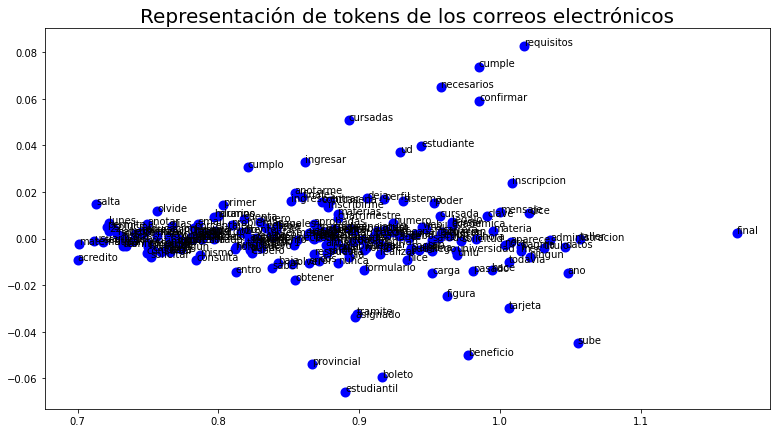

In [71]:
import matplotlib.pyplot as plt

%matplotlib inline

#configuro el tamaño del grafico final
plt.figure(figsize=(13,7))

plt.scatter(result_m0[:,0], result_m0[:,1], linewidths=4, color='blue')
plt.title("Representación de tokens de los correos electrónicos",size=20)

vocab=list(model.wv.vocab)
for i, word in enumerate(vocab):
  if result[i,0] > 0.7:
    plt.annotate(word,xy=(result[i,0],result[i,1]))

plt.show()